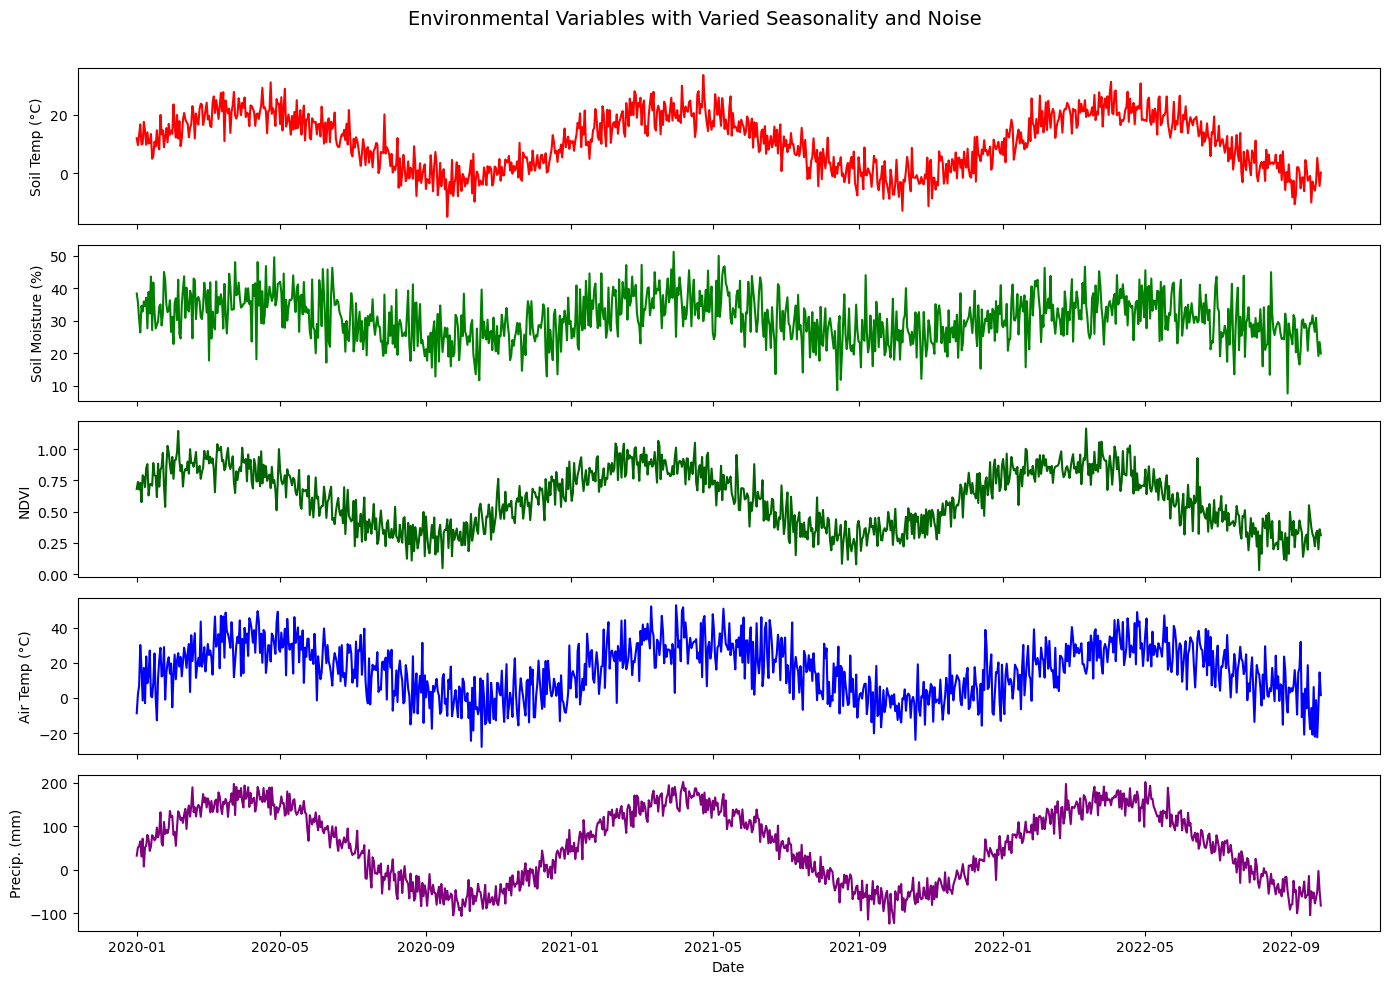

In [125]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
np.random.seed(42)

# Create modified seasonality for each variable
seasonality_base = np.sin(2 * np.pi * days / 365)
seasonality_shifted = np.sin(2 * np.pi * (days + 30) / 365)  # 1-month shift
seasonality_lagged = np.sin(2 * np.pi * (days - 15) / 365)   # 1.5-month lag
seasonality_damp = 0.7 * seasonality_base                   # Reduced amplitude
seasonality_amplified = 3.3 * seasonality_base              # Increased amplitude

# Recreate environmental variables with different seasonalities and noise
soil_temp = 10 + 12 * seasonality_base + np.random.normal(0, 4, 1000)
soil_moisture = 30 + 8 * seasonality_damp + np.random.normal(0, 6, 1000)
NDVI = 0.6 + 0.3 * seasonality_shifted + np.random.normal(0, 0.1, 1000)
air_temp = 15 + 18 * seasonality_lagged + np.random.normal(0, 10, 1000)
precipitation = 50 + 35 * seasonality_amplified + np.random.normal(0, 20, 1000)
land_cover = np.random.choice([1, 2, 3, 4], 1000)

# Update DataFrame
variable_df = pd.DataFrame({
    'date': dates,
    'Soil Temperature (°C)': soil_temp,
    'Soil Moisture (%)': soil_moisture,
    'NDVI': NDVI,
    'Air Temperature (°C)': air_temp,
    'Precipitation (mm)': precipitation,
    'Land Cover Type': land_cover
})

# Multi-panel plot with varied seasonality and noise
fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

axs[0].plot(variable_df['date'], variable_df['Soil Temperature (°C)'], color='red')
axs[0].set_ylabel("Soil Temp (°C)")

axs[1].plot(variable_df['date'], variable_df['Soil Moisture (%)'], color='green')
axs[1].set_ylabel("Soil Moisture (%)")

axs[2].plot(variable_df['date'], variable_df['NDVI'], color='darkgreen')
axs[2].set_ylabel("NDVI")

axs[3].plot(variable_df['date'], variable_df['Air Temperature (°C)'], color='blue')
axs[3].set_ylabel("Air Temp (°C)")

axs[4].plot(variable_df['date'], variable_df['Precipitation (mm)'], color='purple')
axs[4].set_ylabel("Precip. (mm)")
axs[4].set_xlabel("Date")

plt.suptitle("Environmental Variables with Varied Seasonality and Noise", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

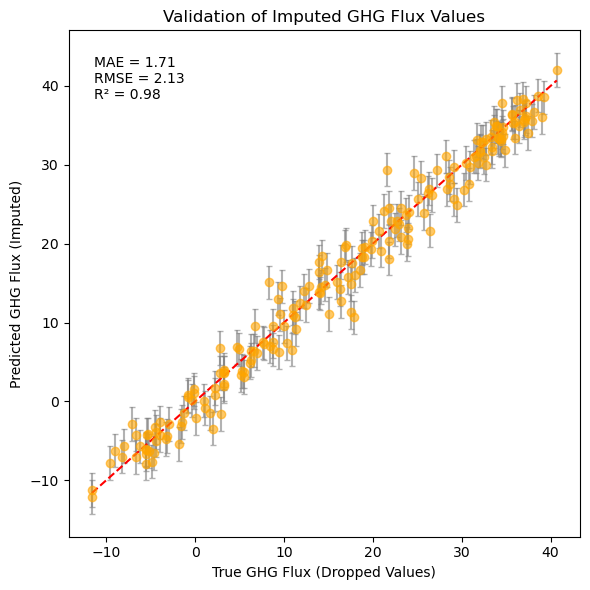

In [126]:
# Plot true vs predicted values for the imputed points with error bars and metric annotations
plt.figure(figsize=(6, 6))

# Plot scatter with RMSE error bars
plt.errorbar(true_values, predicted_values, yerr=rmse, fmt='o', color="orange", alpha=0.6,
             ecolor='gray', capsize=2, label='RF Predictions ± RMSE')

# Plot 1:1 line
plt.plot([true_values.min(), true_values.max()],
         [true_values.min(), true_values.max()],
         '--', color='red', label='1:1 Line')

# Labels and title
plt.xlabel("True GHG Flux (Dropped Values)")
plt.ylabel("Predicted GHG Flux (Imputed)")
plt.title("Validation of Imputed GHG Flux Values")

# Add annotation with metrics
metrics_text = f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR² = {r2:.2f}"
plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="1"))
plt.tight_layout()
plt.show()

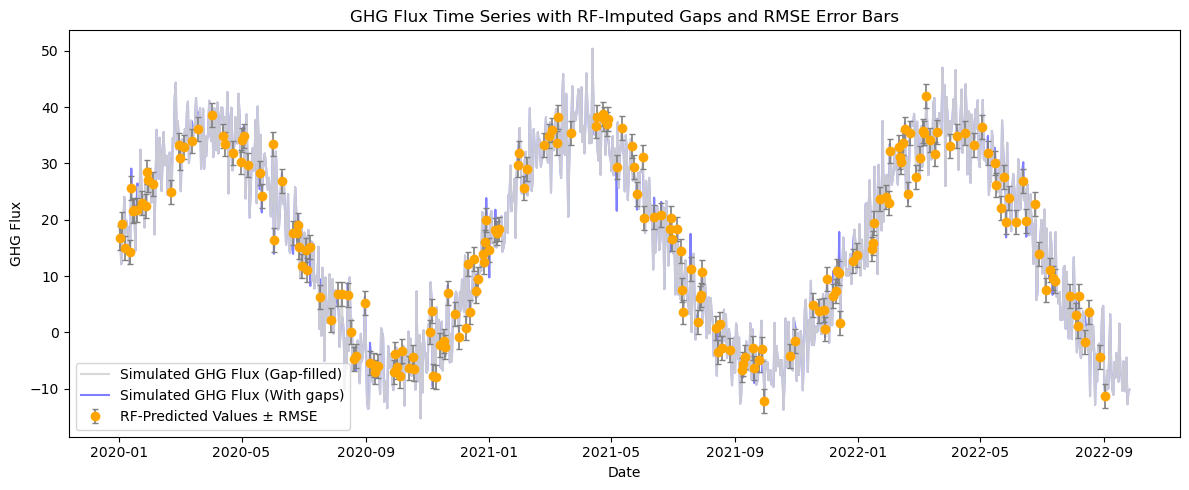

In [127]:
# Plot full time series with RMSE error bars on imputed points
plt.figure(figsize=(12, 5))
plt.plot(data['date'], data['GHG_flux_missing'], label='Simulated GHG Flux (Gap-filled)', color='lightgray', alpha=0.9, zorder=1)
plt.errorbar(data.loc[missing_indices_y, 'date'],
             predicted_values,
             yerr=rmse,
             fmt='o',
             color='orange',
             ecolor='gray',
             elinewidth=1.2,
             capsize=2,
             label=f'RF-Predicted Values ± RMSE',
             zorder=2)
plt.plot(data['date'], data['GHG_flux'], label='Simulated GHG Flux (With gaps)', color='blue', alpha=0.5, zorder=0)
plt.xlabel("Date")
plt.ylabel("GHG Flux")
plt.title("GHG Flux Time Series with RF-Imputed Gaps and RMSE Error Bars")
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
# Define features and target
X = data.drop(columns=['GHG_flux','GHG_flux_missing', 'date'])
y = data['GHG_flux']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve best model
rf_best = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
y_pred = rf_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nPerformance of Best Model:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Performance of Best Model:
Mean Absolute Error (MAE): 1.711
Root Mean Squared Error (RMSE): 2.130
R² Score: 0.983


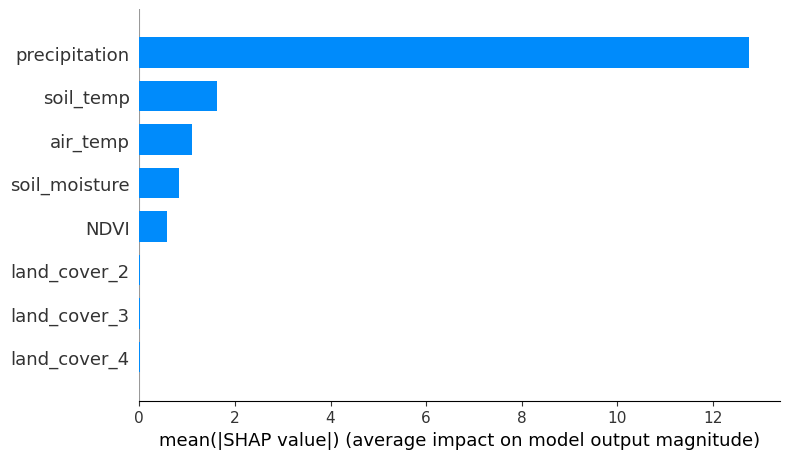

In [129]:
import shap

# see https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_test)

# Bar plot for global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

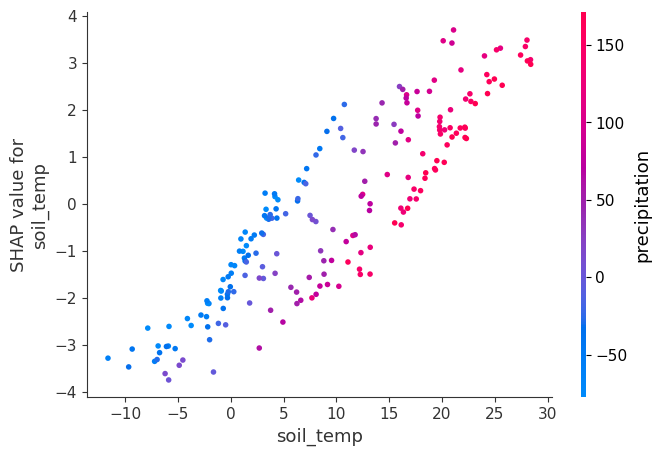

In [130]:
# examining nonlinear effects or interactions of one feature. Color = another feature that's most correlated (interaction).
shap.dependence_plot('soil_temp', shap_values, X_test)

In [132]:
# Force plot. See https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [133]:
# Generate the interactive SHAP force plot for the full test set
force_plot = shap.force_plot(explainer.expected_value, shap_values, X_test)

In [134]:
# Save to HTML
shap.save_html("shap_force_plot_full.html", force_plot)

In [ ]:
# Save force plot to standalone HTML file
plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

shap.save_html("shap_force_plot_sample.html", plot)

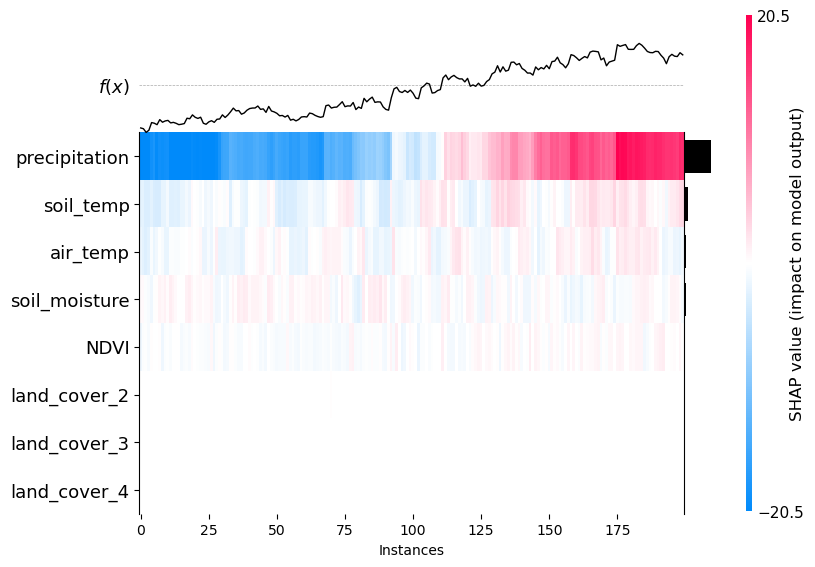

<Axes: xlabel='Instances'>

In [139]:
shap_heatmap = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

shap.plots.heatmap(shap_heatmap)

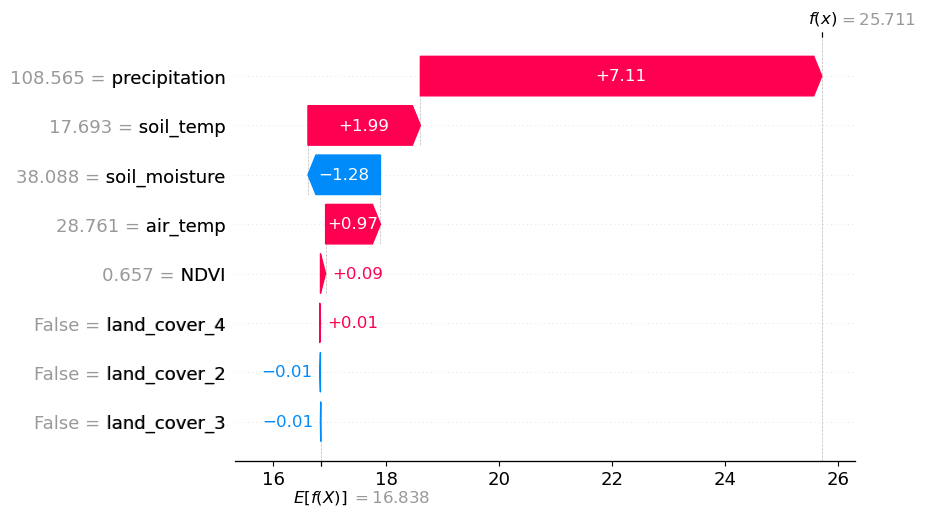

In [141]:
i = 0  # or any index between 0 and len(X_test) - 1

shap.waterfall_plot(shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_test.iloc[i]
))

# Wrap shap_values into an Explanation object
shap_exp = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

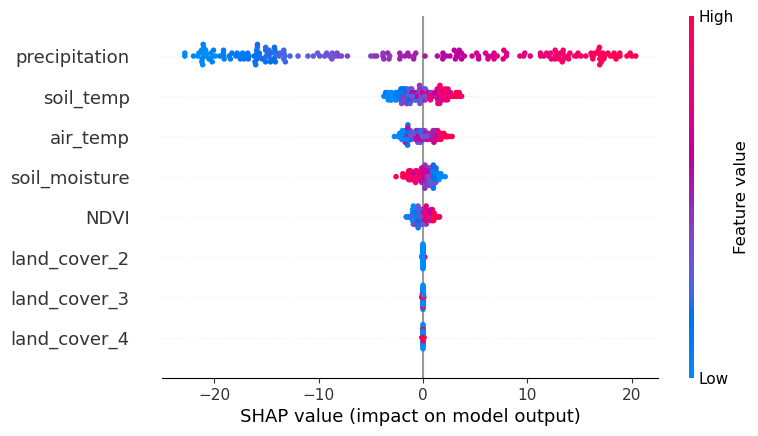

In [142]:
# Now plot the beeswarm
shap.plots.beeswarm(shap_exp)

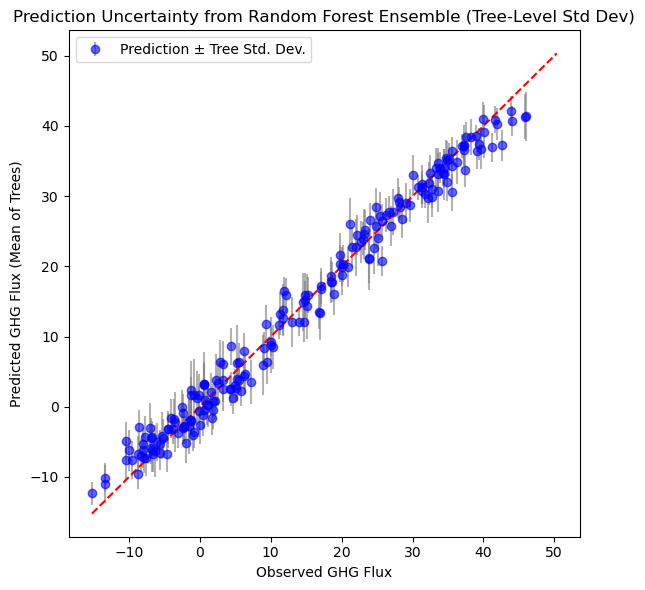

In [143]:
# Get predictions from all individual trees in the forest
all_tree_preds = np.stack([tree.predict(X_test.values) for tree in rf_best.estimators_])

# Compute mean and standard deviation per test sample
y_pred_mean = np.mean(all_tree_preds, axis=0)
y_pred_std = np.std(all_tree_preds, axis=0)

# Plot predicted vs observed with uncertainty from tree variance
plt.figure(figsize=(6, 6))
plt.errorbar(
    y_test, y_pred_mean,
    yerr=y_pred_std,
    fmt='o',
    ecolor='gray',
    alpha=0.6,
    color='blue',
    label='Prediction ± Tree Std. Dev.'
)

# Add 1:1 line for reference
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', label='')

# Axis labels and plot title
plt.xlabel("Observed GHG Flux")
plt.ylabel("Predicted GHG Flux (Mean of Trees)")
plt.title("Prediction Uncertainty from Random Forest Ensemble (Tree-Level Std Dev)")
plt.legend()
plt.tight_layout()
plt.show()

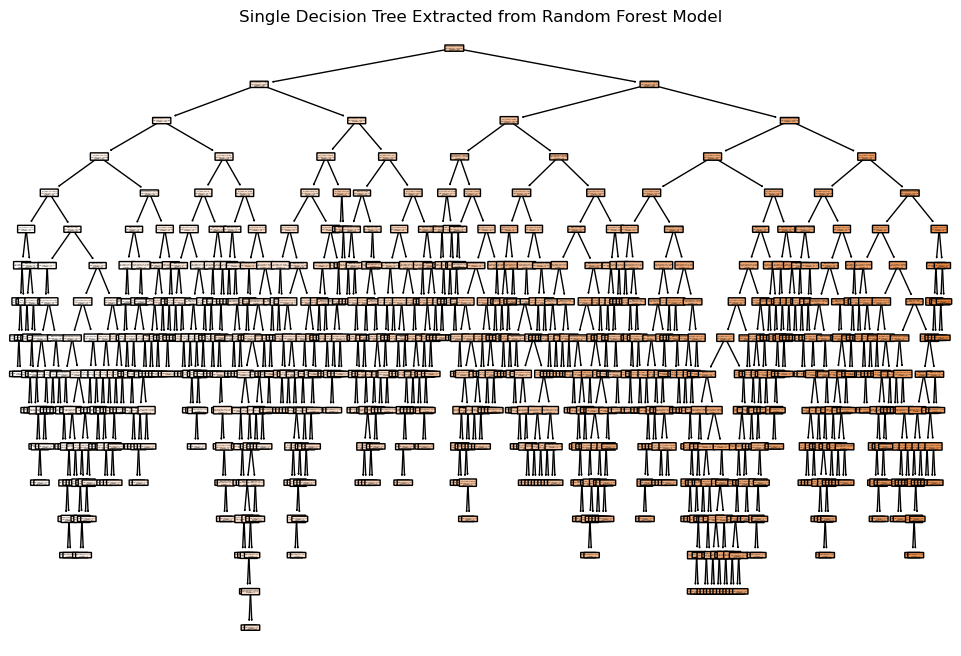

In [144]:
from sklearn.tree import plot_tree
# Extract a single tree from the trained Random Forest model
single_tree_from_rf = rf_best.estimators_[0]  # Take the first tree from the trained Random Forest

# Plot the extracted decision tree
plt.figure(figsize=(12, 8))
plot_tree(single_tree_from_rf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Single Decision Tree Extracted from Random Forest Model")
plt.show()

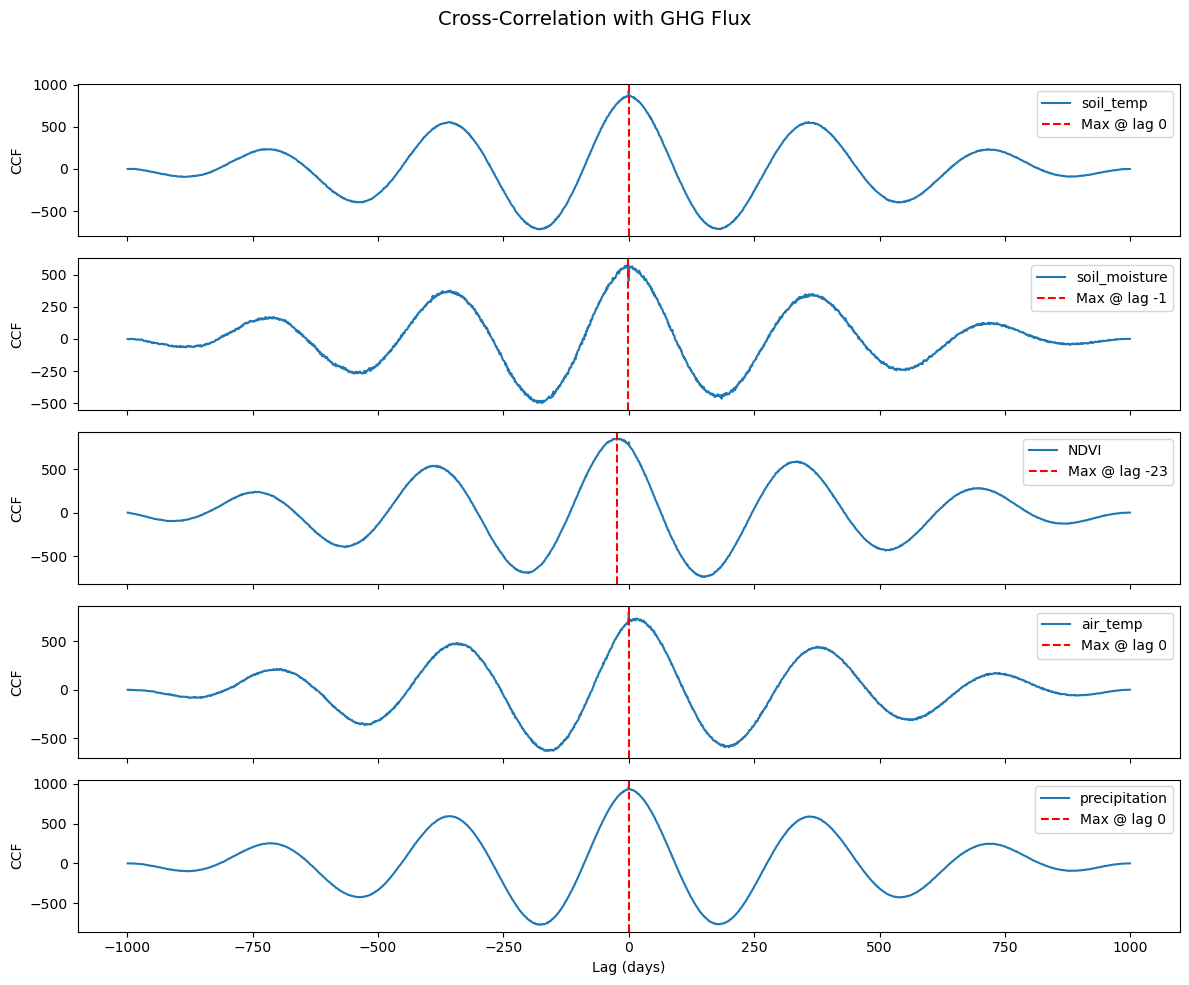

In [145]:
from scipy.signal import correlate
from scipy.stats import zscore

# Select only continuous predictors for cross-correlation
predictor_cols_ccf = ['soil_temp', 'soil_moisture', 'NDVI', 'air_temp', 'precipitation']
target_series = zscore(data['GHG_flux'].values)

# Set up subplot
fig, axs = plt.subplots(len(predictor_cols_ccf), 1, figsize=(12, 2 * len(predictor_cols_ccf)), sharex=True)

# Store results
lag_results = []

for i, feature in enumerate(predictor_cols_ccf):
    predictor_series = zscore(data[feature].values)

    # Compute cross-correlation
    ccf = correlate(predictor_series, target_series, mode='full')
    lags = np.arange(-len(predictor_series) + 1, len(predictor_series))

    # Find max correlation and corresponding lag
    max_idx = np.argmax(ccf)
    max_corr = ccf[max_idx]
    best_lag = lags[max_idx]
    lag_results.append((feature, best_lag, max_corr))

    # Plot
    axs[i].plot(lags, ccf, label=f'{feature}')
    axs[i].axvline(best_lag, color='red', linestyle='--', label=f'Max @ lag {best_lag}')
    axs[i].set_ylabel("CCF")
    axs[i].legend()

axs[-1].set_xlabel("Lag (days)")
plt.suptitle("Cross-Correlation with GHG Flux", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

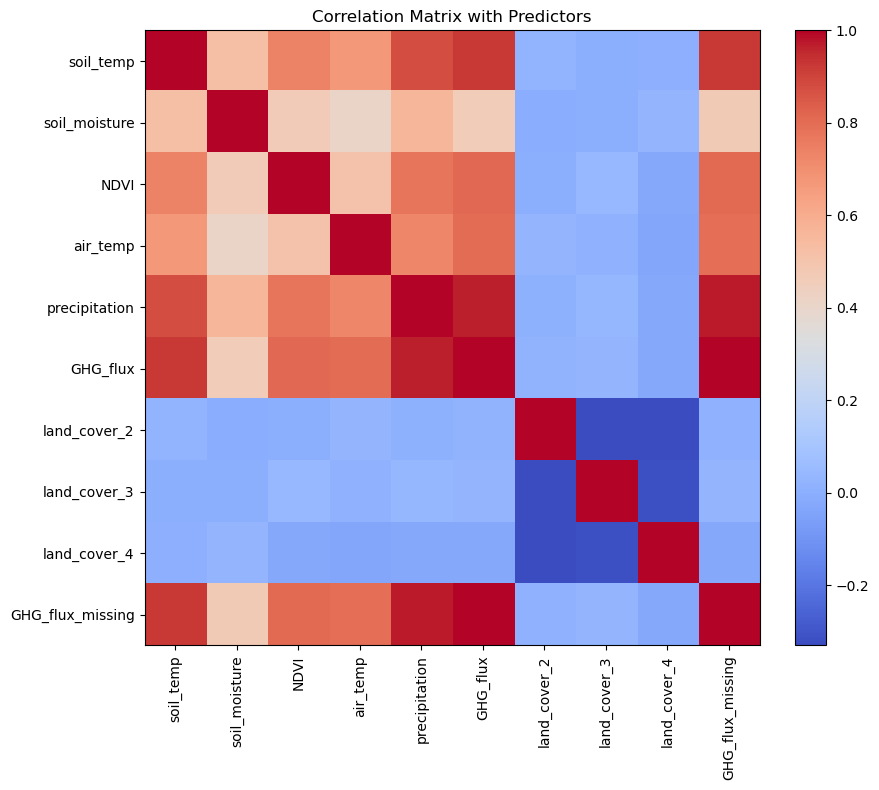

In [146]:
# Display results as DataFrame
lag_df = pd.DataFrame(lag_results, columns=['Feature', 'Lag (days)', 'Max Correlation'])
lag_df.sort_values(by='Lag (days)', inplace=True)

# Compute correlation matrix including GHG_flux and predictors
corr_matrix = data.corr(numeric_only=True)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation Matrix with Predictors")
plt.tight_layout()
plt.show()

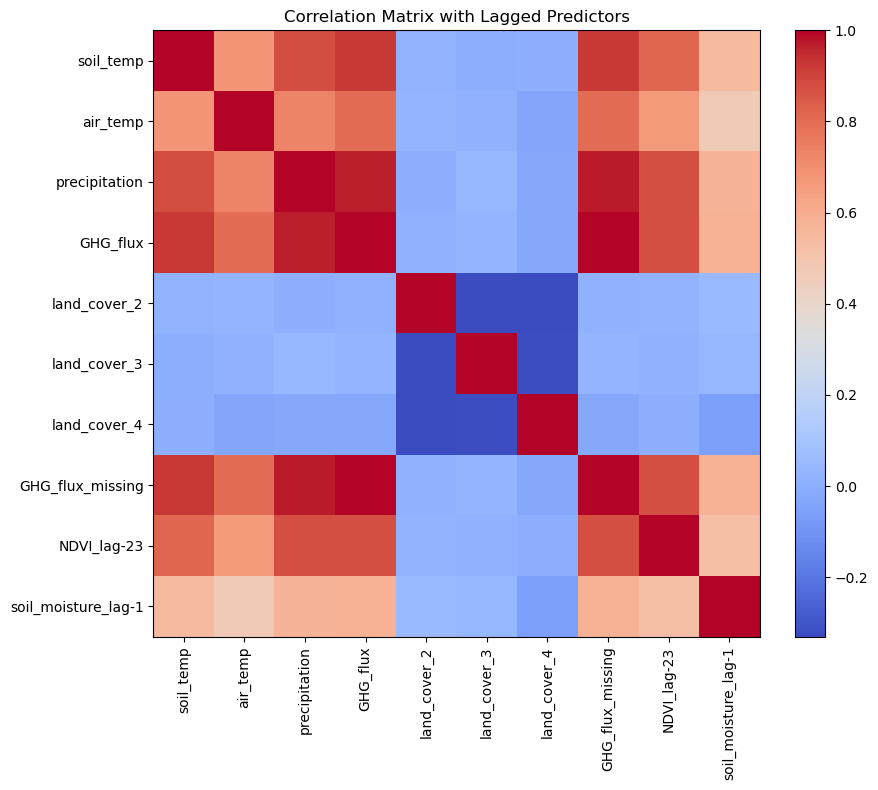

In [147]:
# Create a new DataFrame for lagged predictors using the optimal lags
lagged_data = data.copy()

# Apply lags from lag_df
for _, row in lag_df.iterrows():
    feature = row['Feature']
    lag = int(row['Lag (days)'])

    if lag != 0:
        # Create new lagged column and shift the original
        lagged_col = f"{feature}_lag{lag}"
        lagged_data[lagged_col] = lagged_data[feature].shift(-lag)

# Drop original unlagged features if they were replaced
features_to_drop = [row['Feature'] for _, row in lag_df.iterrows() if int(row['Lag (days)']) != 0]
lagged_data = lagged_data.drop(columns=features_to_drop)

# Drop any rows with NaNs from shifting
lagged_data = lagged_data.dropna().reset_index(drop=True)

# Compute correlation matrix including GHG_flux and lagged predictors
corr_matrix = lagged_data.corr(numeric_only=True)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation Matrix with Lagged Predictors")
plt.tight_layout()
plt.show()

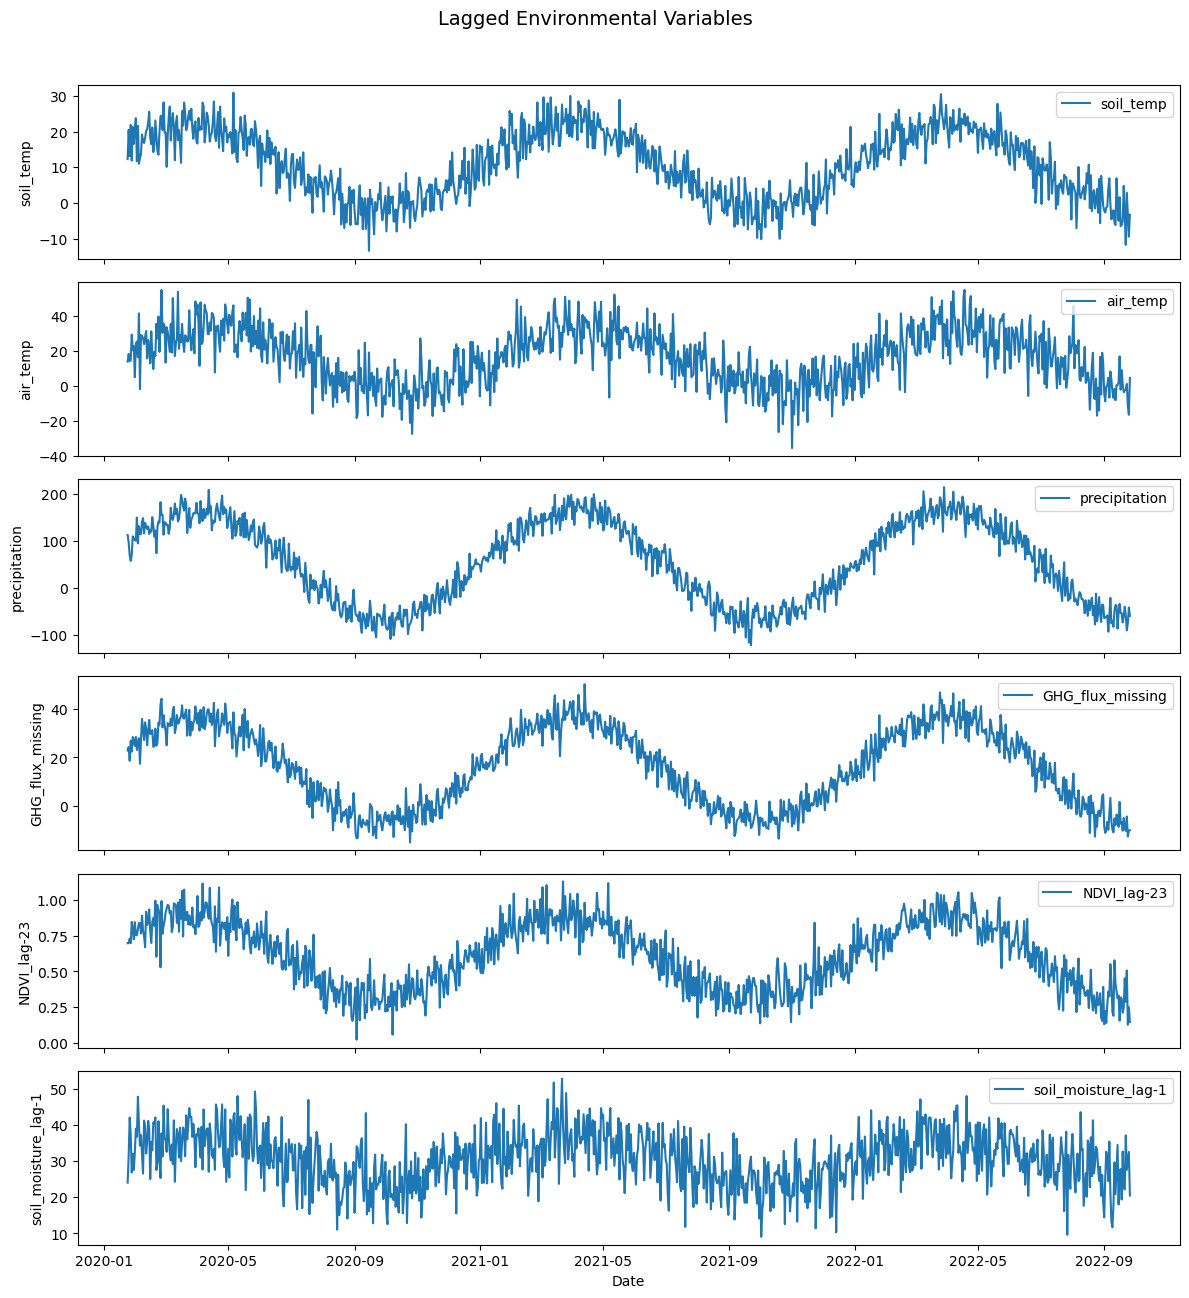

In [148]:
# Filter out any land cover columns in addition to GHG_flux and date
columns_to_plot = [col for col in lagged_data.columns if col != "GHG_flux" and col != "date" and not col.startswith("land_cover")]

# Create multi-panel plot for lagged variables (excluding land cover)
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(12, 2.2 * len(columns_to_plot)), sharex=True)

for i, col in enumerate(columns_to_plot):
    axs[i].plot(lagged_data['date'], lagged_data[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc='upper right')

axs[-1].set_xlabel("Date")
plt.suptitle("Lagged Environmental Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()